## Importing Basic libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

## Read data

In [3]:
df = pd.read_csv('D:\DataScienceProjects\Chicago_Public_Schools_-_High_School_Progress_Report__2013-2014__20250717.csv')

### Selecting necesaary columns for classification and prediction of 'Healthy Schools Certification'

In [5]:
selected_columns = [
    # Target variable
    'Healthy Schools Certification',

    # 1. Attendance
    'Student Attendance Percentage 2013',
    'Teacher Attendance Percentage 2013',

    # 2. Discipline / Safety
    'Suspensions Per 100 2013',
    'Percentage of Misconducts Resulting in Suspension 2013',
    'Average Length of Suspensions 2013',
    'Safe',

    # 3. School Climate & Surveys
    'My Voice, My School Overall Rating',
    'Involved Family',
    'Supportive Environment',
    'Collaborative Teachers',
    'Ambitious Instruction',
    'Effective Leaders',
    'School Community',
    'Parent-Teacher Partnership',

    # 4. Academic Engagement
    'Gr3-8 On-Track Percentage 2013',
    'Freshmen-on-Track Rate Percentage 2013',
    'One-Year DropOut Rate Percentage 2013'
]

### Remove rows of 'pending certifications' since they dont provide any information

In [10]:
df_selected = df[selected_columns]
df_selected = df_selected[df_selected['Healthy Schools Certification'] != 'PENDING CERTIFICATION']

### Visualizing the NULL value frequency

['Student Attendance Percentage 2013', 'Teacher Attendance Percentage 2013', 'Suspensions Per 100 2013', 'Percentage of Misconducts Resulting in Suspension 2013', 'Average Length of Suspensions 2013', 'School Community', 'Parent-Teacher Partnership', 'Gr3-8 On-Track Percentage 2013', 'Freshmen-on-Track Rate Percentage 2013', 'One-Year DropOut Rate Percentage 2013']


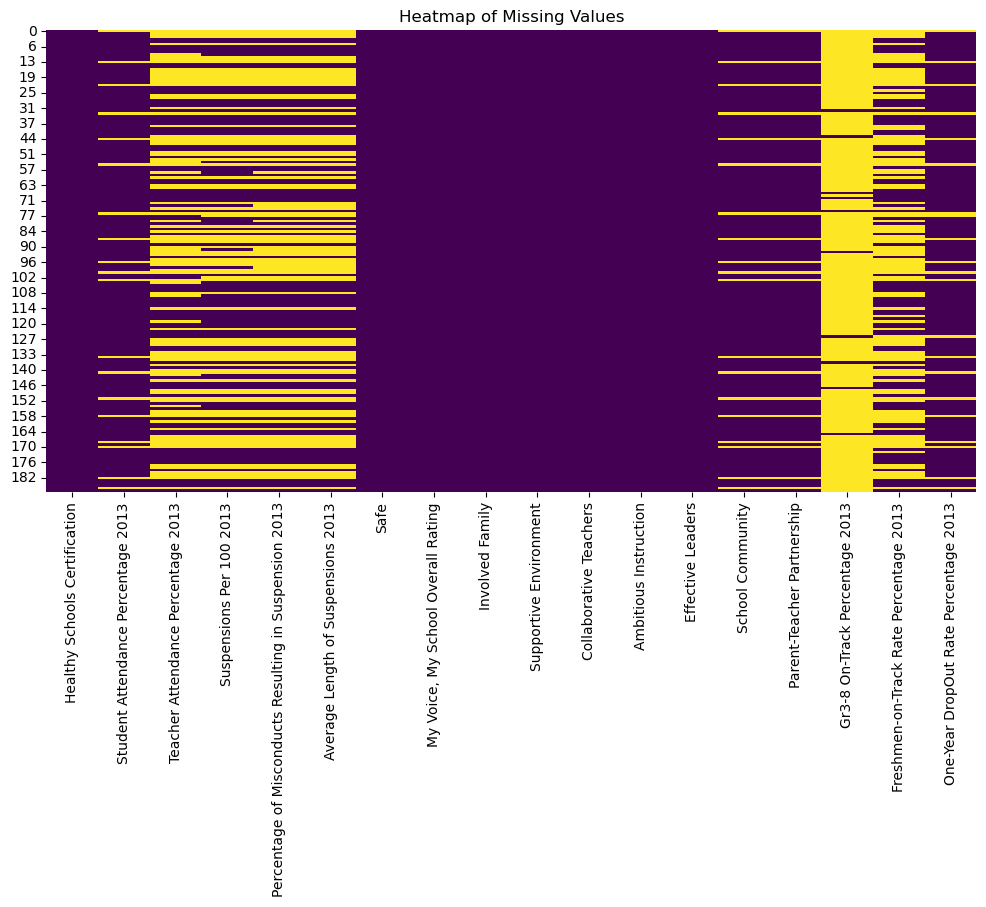

Student Attendance Percentage 2013 11.0  % missing values
Teacher Attendance Percentage 2013 51.0  % missing values
Suspensions Per 100 2013 46.0  % missing values
Percentage of Misconducts Resulting in Suspension 2013 49.0  % missing values
Average Length of Suspensions 2013 49.0  % missing values
School Community 11.0  % missing values
Parent-Teacher Partnership 11.0  % missing values
Gr3-8 On-Track Percentage 2013 94.0  % missing values
Freshmen-on-Track Rate Percentage 2013 56.00000000000001  % missing values
One-Year DropOut Rate Percentage 2013 12.0  % missing values


In [13]:
# Identify all columns in the DataFrame `df` that have more than 1 missing (NaN) value,
# and store their names in the list `Columns_having_nan`
Columns_having_nan=[i for i in df_selected.columns if df_selected[i].isnull().sum()>1]
print(Columns_having_nan)

# Create a heatmap to visualize missing (NaN) values in the DataFrame `df`
# - A yellow/light cell indicates a missing value
# - A dark cell indicates a non-missing value

plt.figure(figsize=(12,6))
sns.heatmap(df_selected.isnull(), cbar=False, cmap='viridis')
plt.title("Heatmap of Missing Values")
plt.show()

for i in Columns_having_nan:
    print(i, (np.round(df_selected[i].isnull().mean(), 2))*100,  ' % missing values')

### Removing Null Values by removing columns with 80% null values, by replacing missing values of columns with Median, mode and mean based on the column data 

In [16]:
#dropping columns with more than 80 %
df_selected.drop(columns=['Gr3-8 On-Track Percentage 2013','Freshmen-on-Track Rate Percentage 2013'], inplace=True)
df_selected['Student Attendance Percentage 2013'].fillna(df_selected['Student Attendance Percentage 2013'].median(), inplace=True)
mode_value_SchoolCommunity = df_selected['School Community'].mode().iloc[0]
df_selected['School Community'] = df_selected['School Community'].fillna(mode_value_SchoolCommunity)

In [18]:
mode_value_PTP =  df_selected['Parent-Teacher Partnership'].mode().iloc[0]
df_selected['Parent-Teacher Partnership'] = df_selected['Parent-Teacher Partnership'].fillna(mode_value_PTP)

In [20]:
df_selected['One-Year DropOut Rate Percentage 2013'].fillna(df_selected['One-Year DropOut Rate Percentage 2013'].mean(), inplace=True)


### Data Preprocessing: Feature Scaling, Encoding Ordinal Features & Missing Value Flags

In [23]:
# scale for columns - Safe, Involved Family, Supportive Environment, Collaborative Teachers, Ambitious Instruction, Effective Leaders, School Community
# Parent-Teacher Partnership
ordinal_scale_cols = [
    'Safe',
    'Involved Family',
    'Supportive Environment',
    'Collaborative Teachers',
    'Ambitious Instruction',
    'Effective Leaders',
    'School Community',
    'Parent-Teacher Partnership'
]
ordinal_scale_for_safe = {
    'NOT ENOUGH DATA': 0,      
    'VERY WEAK': 1,
    'WEAK': 2,
    'NEUTRAL': 3,
    'STRONG': 4,
    'VERY STRONG': 5
}

In [25]:
# scale for columns - 'My Voice, My School Overall Rating'
School_Rating_Scale_cols =['My Voice, My School Overall Rating']
School_Rating_scale = {
    'NOT ENOUGH DATA': 0,           
    'NOT YET ORGANIZED': 1,
    'PARTIALLY ORGANIZED': 2,
    'MODERATELY ORGANIZED': 3,
    'ORGANIZED': 4,
    'WELL-ORGANIZED': 5
}

In [27]:
for col in ordinal_scale_cols:
    df_selected[col] = df_selected[col].map(ordinal_scale_for_safe)
df_selected['My Voice, My School Overall Rating'] = df_selected['My Voice, My School Overall Rating'].map(School_Rating_scale)


In [29]:
label_map = {
    'HEALTHY SCHOOLS CERTIFIED': 1,
    'NOT CERTIFIED': 0
}
df_selected['Healthy Schools Certification'] = df_selected['Healthy Schools Certification'].map(label_map)

In [31]:
cols_to_flag = [
    'Teacher Attendance Percentage 2013',
    'Suspensions Per 100 2013',
    'Percentage of Misconducts Resulting in Suspension 2013',
    'Average Length of Suspensions 2013'
]

for col in cols_to_flag:
    df_selected[f'{col} Missing'] = df_selected[col].isnull().astype(int)


###  KNN Imputation for some Missing Numeric Features

In [34]:

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# Your selected DataFrame
# df_selected = your loaded and preprocessed DataFrame

# Step 1: Define columns to impute
cols_to_impute = [
    'Teacher Attendance Percentage 2013',
    'Suspensions Per 100 2013',
    'Percentage of Misconducts Resulting in Suspension 2013',
    'Average Length of Suspensions 2013'
]

# Step 2: Preserve original missing indicators (optional but useful for modeling)
for col in cols_to_impute:
    df_selected[f'{col} Missing'] = df_selected[col].isnull().astype(int)

# Step 3: Standardize only the columns to be imputed
scaler = StandardScaler()
scaled_cols = scaler.fit_transform(df_selected[cols_to_impute])

# Step 4: Apply KNN imputer
imputer = KNNImputer(n_neighbors=5)
imputed_scaled = imputer.fit_transform(scaled_cols)

# Step 5: Inverse scale to restore original units
imputed_values = scaler.inverse_transform(imputed_scaled)

# Step 6: Replace original columns with imputed values
df_selected[cols_to_impute] = imputed_values

# Done 
print(" KNN imputation complete on selected columns.")
print(df_selected[cols_to_impute].isnull().sum())  # Verify all NaNs are handled


 KNN imputation complete on selected columns.
Teacher Attendance Percentage 2013                        0
Suspensions Per 100 2013                                  0
Percentage of Misconducts Resulting in Suspension 2013    0
Average Length of Suspensions 2013                        0
dtype: int64


### Now drop the flagged columns

In [37]:
df_selected.drop(columns=['Teacher Attendance Percentage 2013 Missing','Suspensions Per 100 2013 Missing','Percentage of Misconducts Resulting in Suspension 2013 Missing','Average Length of Suspensions 2013 Missing'], inplace=True)


### Now scaled the numerical columns that are imputed using KNN and other columns that are not scaled

In [40]:
columns_to_scale = [
    'Student Attendance Percentage 2013',
    'Teacher Attendance Percentage 2013',
    'Suspensions Per 100 2013',
    'Percentage of Misconducts Resulting in Suspension 2013',
    'Average Length of Suspensions 2013',
    'One-Year DropOut Rate Percentage 2013'
]
df_selected[columns_to_scale] = scaler.fit_transform(df_selected[columns_to_scale])

### Training the data in to train and split

In [43]:
from sklearn.model_selection import train_test_split

# Suppose your dataframe is df_selected
# Separate features and target
X = df_selected.drop(columns=['Healthy Schools Certification'])
y = df_selected['Healthy Schools Certification']

# Split into train and test (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Random Forest Classification with Hyperparameter Tuning (Grid Search)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Hyperparameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Test Accuracy: 0.9444444444444444
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        34
           1       0.00      0.00      0.00         2

    accuracy                           0.94        36
   macro avg       0.47      0.50      0.49        36
weighted avg       0.89      0.94      0.92        36



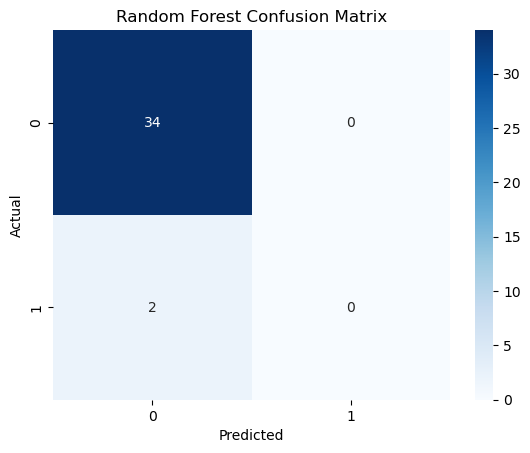

In [46]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare features and target
X = df_selected.drop(columns=['Healthy Schools Certification'])
y = df_selected['Healthy Schools Certification']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Resample training data with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Define parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],         # number of trees
    'max_depth': [None, 10, 20, 30],        # max depth of trees
    'min_samples_split': [2, 5, 10],        # min samples to split node
    'min_samples_leaf': [1, 2, 4],          # min samples in leaf
    'bootstrap': [True, False]               # bootstrap sampling
}

# Create Random Forest model
rf = RandomForestClassifier(random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,               # 3-fold cross-validation
    n_jobs=-1,          # use all cores
    scoring='accuracy', # optimize for accuracy
    verbose=2
)

# Fit grid search on resampled training data
grid_search.fit(X_train_res, y_train_res)

# Best parameters
print("Best Hyperparameters:", grid_search.best_params_)

# Best model from grid search
best_rf = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_rf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### Comparing Multiple Classification Algorithms with SMOTE & ROC Analysis

Original training set class distribution:
Healthy Schools Certification
0    138
1      6
Name: count, dtype: int64
Resampled training set class distribution:
Healthy Schools Certification
0    138
1    138
Name: count, dtype: int64

Random Forest Performance:
Accuracy: 0.8888888888888888
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        34
           1       0.00      0.00      0.00         2

    accuracy                           0.89        36
   macro avg       0.47      0.47      0.47        36
weighted avg       0.89      0.89      0.89        36


Logistic Regression Performance:
Accuracy: 0.7777777777777778
              precision    recall  f1-score   support

           0       0.96      0.79      0.87        34
           1       0.12      0.50      0.20         2

    accuracy                           0.78        36
   macro avg       0.54      0.65      0.54        36
weighted avg       0.92      0.78      0.83     

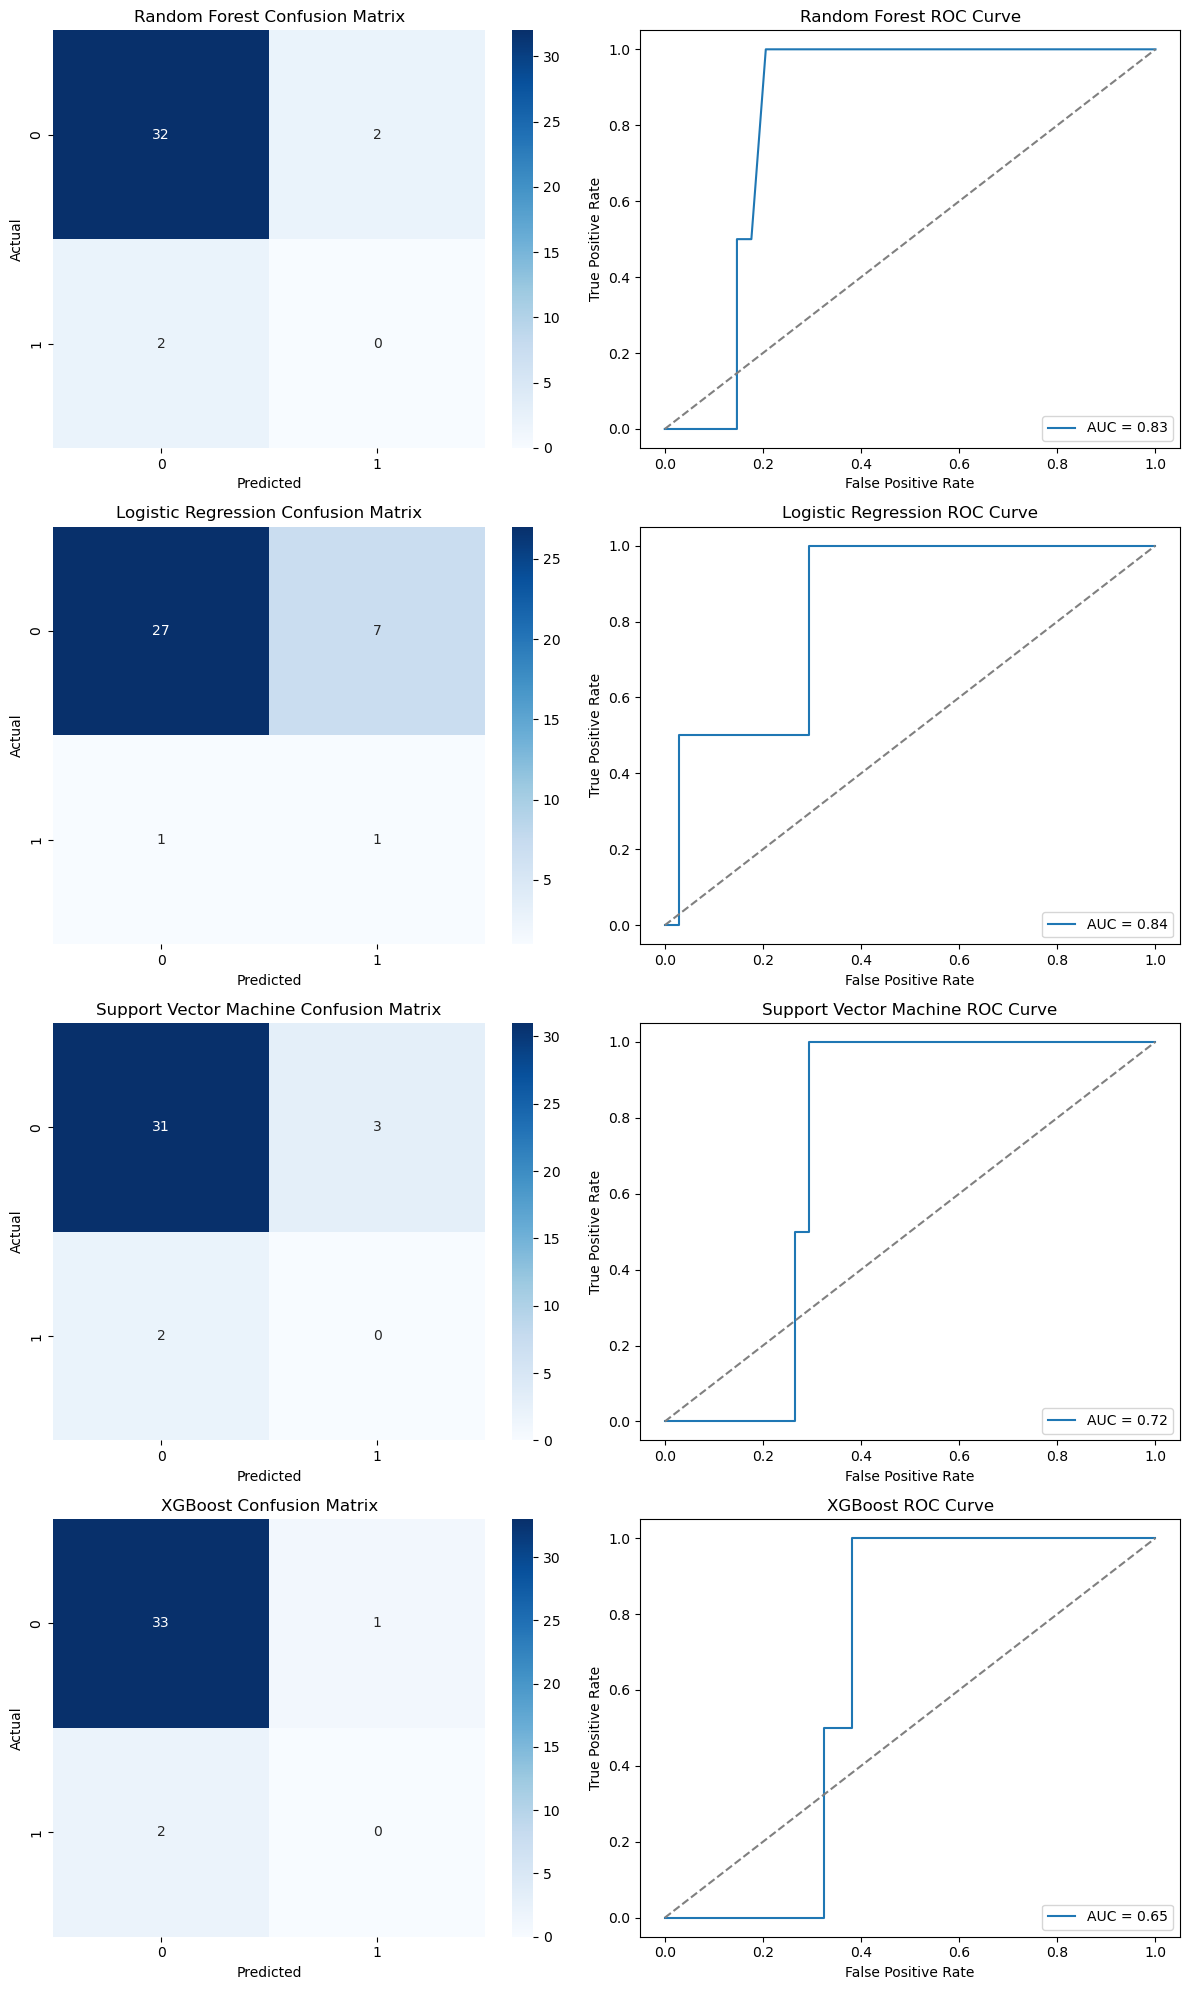

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from xgboost import XGBClassifier

# Prepare features and target
X = df_selected.drop(columns=['Healthy Schools Certification'])
y = df_selected['Healthy Schools Certification']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Resample training data with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f'Original training set class distribution:\n{y_train.value_counts()}')
print(f'Resampled training set class distribution:\n{pd.Series(y_train_res).value_counts()}')

# Define classifiers to try
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Initialize matplotlib subplots
fig, axes = plt.subplots(len(models), 2, figsize=(12, 5 * len(models)))

for i, (name, model) in enumerate(models.items()):
    # Train
    model.fit(X_train_res, y_train_res)
    # Predict labels
    y_pred = model.predict(X_test)
    # Predict probabilities for ROC curve
    y_proba = model.predict_proba(X_test)[:, 1]

    # Print performance
    print(f"\n{name} Performance:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i, 0])
    axes[i, 0].set_title(f"{name} Confusion Matrix")
    axes[i, 0].set_xlabel("Predicted")
    axes[i, 0].set_ylabel("Actual")

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    axes[i, 1].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    axes[i, 1].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axes[i, 1].set_title(f"{name} ROC Curve")
    axes[i, 1].set_xlabel("False Positive Rate")
    axes[i, 1].set_ylabel("True Positive Rate")
    axes[i, 1].legend(loc='lower right')

plt.tight_layout()
plt.show()


In [52]:
import os
print(os.getcwd())

C:\Users\vishw\Documents\PythonProjects
